In [35]:
import numpy as np
import yt
import unyt
from yt import YTArray
from yt.data_objects.level_sets.api import Clump, find_clumps
import argparse
import os
from astropy.table import Table
from astropy.io import ascii
import multiprocessing as multi


import datetime
from scipy import interpolate
import shutil
import matplotlib.pyplot as plt
import cmasher as cmr
import matplotlib.colors as mcolors
import h5py
import trident

# These imports are FOGGIE-specific files
from foggie.utils.consistency import *
from foggie.utils.get_run_loc_etc import get_run_loc_etc
from foggie.utils.yt_fields import *
from foggie.utils.foggie_load import *
from foggie.utils.analysis_utils import *

# These imports for datashader plots
import datashader as dshader
from datashader.utils import export_image
import datashader.transfer_functions as tf
import pandas as pd


import matplotlib as mpl
import numpy as np
from yt.units.yt_array import YTQuantity
from scipy.ndimage import gaussian_filter
import matplotlib.cm as mtcm
from matplotlib.colors import LogNorm

def generate_foggie_paths(halo, run, snap):
    # Define base paths
    foggie_base_dir = "/Users/vidasaeedzadeh/Projects/foggie_data/"
    code_base_path = "/Users/vidasaeedzadeh/Projects/repositories/foggie/foggie/"
    output_base_dir = "/Users/vidasaeedzadeh/Projects/foggie_outputs/"

    # Zero-pad the halo number to 6 digits
    halo_number = halo.zfill(6)

    # Define directory and file paths dynamically
    foggie_dir = os.path.join(foggie_base_dir, f"halo_{halo_number}", run + '/')
    snap_name = os.path.join(foggie_dir, snap, snap)
    halo_c_v_name = os.path.join(code_base_path, f"halo_infos/{halo_number}/{run}/halo_c_v")
    trackname = os.path.join(code_base_path, f"halo_tracks/{halo_number}/nref11n_selfshield_15/halo_track_200kpc_nref9")

    # Output directory (adjust based on needs)
    output_dir = output_base_dir

    # Return paths
    return foggie_dir,code_base_path, snap_name, halo_c_v_name, trackname, output_dir

# specify halo and snapshot
halo = '8508'
run = 'ludicrous/nref13c_nref9f.enhance'
snap = 'DD2520'

foggie_dir,code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, snap)



# System and plotting settings
system = ''  # System you're using
plot = 'emission_FRB'  # Options: emission_map, emission_map_vbins, or emission_FRB or emission_FRB_binsmearing
ions = ['H I','C II','C III','C IV','O VI']#['Lyalpha', 'Halpha', 'C III','SiII','SiIII','SiIV','MgII']
trident_ions = ['H I','C II','C III','C IV','O VI']
Dragonfly_limit = False
Aspera_limit = False
save_suffix = ""
file_suffix = ""

prefix = output_dir + 'ions_halo_00' + halo + '/' + run + '/'
save_path = prefix + f'rotation_curve_plots/'
os.makedirs(save_path, exist_ok=True)  # Ensure the directory exists


# Filtering settings (optional)
segmentation_filter='radial_velocity' # for categorizing inflow vs outflow it can also be 'metallicity'
filter_type = None  # Type of filter, e.g., 'temperature', 'density'
filter_value = None  # Value for the filter, e.g., 1e4 for temperature < 1e4 K

# Add Trident ion fields
def add_ion_fields(ds):
    trident.add_ion_fields(ds, ions=trident_ions)
    return ds


In [36]:
def rotation_curve(ds, bin_width_kpc=2):
    """
    This function creates a plot of the mass-weighted radial velocity (rotation curve)
    vs. distance for ions in the CGM, considering only the data inside the ds.refine_width box size.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Define the box boundaries from refine_width
    refine_width = ds.refine_width
    halo_center_kpc = ds.halo_center_kpc
    data = ds.all_data()

    # Compute coordinates relative to the halo center
    x_coord = data['gas', 'x'].to('kpc')
    y_coord = data['gas', 'y'].to('kpc')
    z_coord = data['gas', 'z'].to('kpc')

    x_pos = x_coord - halo_center_kpc[0]
    y_pos = y_coord - halo_center_kpc[1]
    z_pos = z_coord - halo_center_kpc[2]

    # Filter data to only include points within the refine_width box
    mask = (
        (x_pos >= -refine_width / 2) & (x_pos <= refine_width / 2) &
        (y_pos >= -refine_width / 2) & (y_pos <= refine_width / 2) &
        (z_pos >= -refine_width / 2) & (z_pos <= refine_width / 2)
    )

    # Apply the mask to filter data
    x_pos = x_pos[mask]
    y_pos = y_pos[mask]
    z_pos = z_pos[mask]
    radius = np.sqrt((x_pos**2) + (y_pos**2) + (z_pos**2))

    # Process each ion and its mass field
    for ion, mass_field in ion_mass_fields.items():
        Vr = data['gas', 'radial_velocity_corrected'][mask]
        Mass = data["gas", f"{mass_field}"].to("Msun")[mask]

        # Only consider data with non-zero mass
        idx = np.where(Mass > 0)
        radius_valid = radius[idx]
        Vr_valid = Vr[idx]
        Mass_valid = Mass[idx]

        # Calculate bin edges dynamically
        r_min = radius_valid.min().to_value()
        r_max = radius_valid.max().to_value()
        bin_edges = np.arange(r_min, r_max + bin_width_kpc, bin_width_kpc)
        # Compute mass-weighted radial velocity for each bin
        hist_sum_mass, _ = np.histogram(radius_valid, bins=bin_edges, weights=Mass_valid)
        hist_sum_vr_mass, _ = np.histogram(radius_valid, bins=bin_edges, weights=Vr_valid * Mass_valid)
        Vr_mass_weighted = hist_sum_vr_mass / hist_sum_mass

        # Plot the mass-weighted rotation curve
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        plt.plot(bin_centers, Vr_mass_weighted, linestyle="-", linewidth=2, label=f"Ion: {ion}")

    # Finalize the plot
    plt.xlabel("Radius (kpc)")
    plt.ylabel("Radial Velocity (km/s)")
    plt.xlim(0,200)
    plt.title("Rotation Curve (Mass-Weighted Radial Velocity)")
    plt.legend()
    plt.savefig(save_path + f'rotation_curve_200kpc.png')
    plt.show()


yt : [INFO     ] 2025-01-14 11:05:25,643 Parameters: current_time              = 639.44151531954
yt : [INFO     ] 2025-01-14 11:05:25,643 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-14 11:05:25,643 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-14 11:05:25,644 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-14 11:05:25,644 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-14 11:05:25,644 Parameters: current_redshift          = 5.0084873179923e-06
yt : [INFO     ] 2025-01-14 11:05:25,644 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2025-01-14 11:05:25,645 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2025-01-14 11:05:25,645 Parameters: omega_radiation           = 0
yt : [INFO     ] 2025-01-14 11:05:25,645 Parameters: hubble_constant           = 0.695


Opening snapshot /Users/vidasaeedzadeh/Projects/foggie_data/halo_008508/ludicrous/nref13c_nref9f.enhance/DD2520/DD2520
get_refine_box: using this location:         col1          col2     col3     col4    col5     col6     col7  col8
------------------- -------- -------- ------- -------- -------- ------- ----
4.4408920985006e-16 0.488865 0.470316 0.50854 0.490865 0.472316 0.51054    9


Parsing Hierarchy : 100%|██████████| 14215/14215 [00:00<00:00, 18171.33it/s]
yt : [INFO     ] 2025-01-14 11:05:27,022 Gathering a field list (this may take a moment.)


This halo_c_v file doesn't exist, calculating halo center...
get_halo_center: code_length code_velocity
get_halo_center: obtained the spherical region
get_halo_center: extracted the DM density
get_halo_center: we have obtained the preliminary center
got the velocities
get_halo_center: located the main halo at: [0.48985028266906744, 0.4711954593658448, 0.5095441341400146] [unyt_quantity(0.00155134, 'code_velocity'), unyt_quantity(-0.00169669, 'code_velocity'), unyt_quantity(0.00070822, 'code_velocity')]


yt : [WARNING  ] 2025-01-14 11:05:35,612 The young_stars particle filter already exists. Overriding.
yt : [WARNING  ] 2025-01-14 11:05:35,618 The young_stars3 particle filter already exists. Overriding.
yt : [WARNING  ] 2025-01-14 11:05:35,622 The young_stars8 particle filter already exists. Overriding.
yt : [WARNING  ] 2025-01-14 11:05:35,626 The old_stars particle filter already exists. Overriding.
yt : [WARNING  ] 2025-01-14 11:05:35,631 The stars particle filter already exists. Overriding.
yt : [WARNING  ] 2025-01-14 11:05:35,635 The dm particle filter already exists. Overriding.


filtering young_stars particles...
filtering young_stars3 particles...
filtering young_stars8 particles...
filtering old_stars particles...
filtering stars particles...
filtering dm particles...
using particle type  young_stars  to derive angular momentum


yt : [WARNING  ] 2025-01-14 11:05:46,619 Field ('gas', 'H_p0_number_density') already exists. Not clobbering.
yt : [WARNING  ] 2025-01-14 11:05:46,619 Field ('gas', 'H_p0_density') already exists. Not clobbering.
yt : [WARNING  ] 2025-01-14 11:05:46,619 Field ('gas', 'H_p0_mass') already exists. Not clobbering.


found angular momentum vector


/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_7485/142966805.py:54: RuntimeWarning: divide by zero encountered in divide
  Vr_mass_weighted = hist_sum_vr_mass / hist_sum_mass


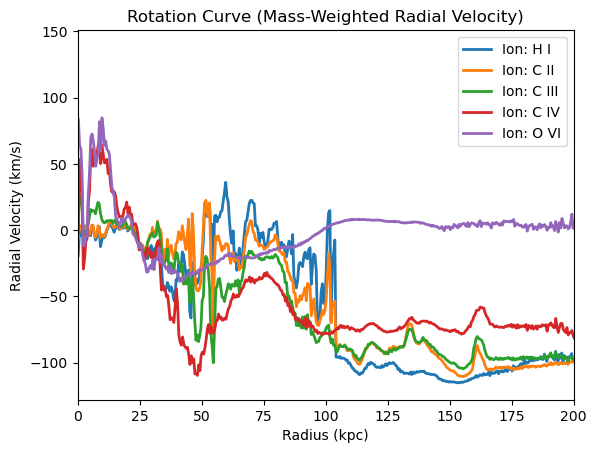

In [37]:
ions_dict = { 'H I':'HAlpha', 'C II': 'CII_1335','C III':'CIII_1910', 
                 'C IV':'CIV_1548','O VI':'OVI'}
label_dict = {'H I':r'H$\alpha$', 'C II':'C II','C III':'C III',
            'C IV':'C IV','O VI':'O VI'}

ions_density_dict = {'H I':'H_p0_density','C II':'C_p1_density', 'C III':'C_p2_density',
                'C IV':'C_p3_density','O VI':'O_p5_density'}
ion_mass_fields = {'H I':'H_p0_mass', 'C II':'C_p1_mass','C III':'C_p2_mass',
                'C IV':'C_p3_mass','O VI':'O_p5_mass'}





snap_name = foggie_dir + snap + '/' + snap
    
ds, refine_box = foggie_load(snap_name, trackname, do_filter_particles=True, halo_c_v_name=halo_c_v_name, disk_relative=True, correct_bulk_velocity=True)

zsnap = ds.get_parameter('CosmologyCurrentRedshift')

# Add ion fields
add_ion_fields(ds)


rotation_curve(ds,bin_width_kpc=0.5)



In [38]:
# Get all loadable fields (raw and derived)
raw_fields = ds.field_list
derived_fields = ds.derived_field_list

# Display fields
#print("Raw Fields:", raw_fields)
#print("Derived Fields:", derived_fields)


In [39]:
derived_fields

[('all', 'age'),
 ('all', 'creation_time'),
 ('all', 'dynamical_time'),
 ('all', 'mesh_id'),
 ('all', 'metallicity_fraction'),
 ('all', 'particle_angular_momentum'),
 ('all', 'particle_angular_momentum_magnitude'),
 ('all', 'particle_angular_momentum_x'),
 ('all', 'particle_angular_momentum_y'),
 ('all', 'particle_angular_momentum_z'),
 ('all', 'particle_index'),
 ('all', 'particle_mass'),
 ('all', 'particle_ones'),
 ('all', 'particle_position'),
 ('all', 'particle_position_cylindrical_radius'),
 ('all', 'particle_position_cylindrical_theta'),
 ('all', 'particle_position_cylindrical_z'),
 ('all', 'particle_position_relative_x'),
 ('all', 'particle_position_relative_y'),
 ('all', 'particle_position_relative_z'),
 ('all', 'particle_position_spherical_phi'),
 ('all', 'particle_position_spherical_radius'),
 ('all', 'particle_position_spherical_theta'),
 ('all', 'particle_position_x'),
 ('all', 'particle_position_y'),
 ('all', 'particle_position_z'),
 ('all', 'particle_radial_velocity'),
 (